# Alphapose 포즈 유사도(similarity) 측정 프로그램
두 영상의 프레임별 포즈 유사도 (Similarity) 측정 프로그램

처리 과정
- 두 영상의 json 데이터를 가져옴
- 두 영상의 json 데이터를 키포인트 배열로 변환 (36 차원 벡터)
- 사용하는 키포인트 데이터만 추출하고 싶은 경우 해당 키포인트만 추출 가능
- 두 영상의 키포인트 36차원 배열을 각각 유클리드 거리 1 로 조정
- 30프레임당 아래의 알고리즘 반복
    - 두 영상 프레임간의 키포인트 36차원 배열간 코사인 유사도 측정
    - 위 코사인 유사도 값으로 다차원 벡터간의 유클리드 거리 계산
    - 계산된 유클리드 거리를 직관적으로 판단하기 위해 가우시안 RBF 정규분포화 적용
    - 30프레임의 평균 RBF 수치 90 미만인 경우 DTW 알고리즘 시작
        - 이 소스의 DTW 알고리즘 : 각각 이전의 한프레임과 1차적으로 매칭, 매칭실패시 이후 사용자의 10프레임까지 탐색
        - 만일 매칭된 두 시퀀스 사이에 0.3 DTW-Euclid 거리 이상의 매칭이 있었던 경우 해당 시퀀스도 평균 데이터에 적용
        - 평균 DTW-RBF 가 90 이상인 경우 현재 두 프레임의 시작 위치를 결과 위치로 변동
        - 평균 DTW-RBF 가 90 미만인 경우 DTW 데이터를 버리고 평균 RBF 수치가 90 미만인 원래 데이터를 전체 데이터에 적용( 다음 30 프레임 시작 위치도 DTW 미적용한 시작점 )
    - 30프레임의 평균 RBF 수치 90 이상인 경우 DTW 를 생략하고 바로 다음 30프레임 포즈 유사도 RBF 연산 시작
    - 마지막 프레임까지 반복
- 연산된 전체 RBF 수치를 데이터 프레임으로 출력


번외
- 이동평균필터를 사용한 그래프 출력 기능(메인메소드 일부 수정 필요)

코드 작성일 : 220621

# Json 데이터 추출 파트
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
- 이미지 , 영상 , 캠(터미널에서만 돌리는 것을 권장) 의 json 데이터 추출 파트

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
- https://github.com/cisco/openh264/releases 에서 openh264 dll 맞는 OS bit 에 따라 다운 (링크 복사 새탭 )
- C:\Windows\System32 에 dll 을 붙여넣기 ( 1.8.0 )

현재 디렉토리 위치 변경

In [1]:
import os
os.chdir('C:\AR_project\AlphaPose')
print(os.getcwd())


C:\AR_project\AlphaPose


# demo_inference.py 인자로 가능 한 것

demo_inference.py [-h] --cfg CFG --checkpoint CHECKPOINT [--sp]
                         [--detector DETECTOR] [--detfile DETFILE]
                         [--indir INPUTPATH] [--list INPUTLIST]
                         [--image INPUTIMG] [--outdir OUTPUTPATH] [--save_img]
                         [--vis] [--showbox] [--profile] [--format FORMAT]
                         [--min_box_area MIN_BOX_AREA] [--detbatch DETBATCH]
                         [--posebatch POSEBATCH] [--eval] [--gpus GPUS]
                         [--qsize QSIZE] [--flip] [--debug] [--video VIDEO]
                         [--webcam WEBCAM] [--save_video] [--vis_fast]
                         [--pose_flow] [--pose_track]
                         
                         """----------------------------- Demo options -----------------------------"""
- parser = argparse.ArgumentParser(description='AlphaPose Demo')
- parser.add_argument('--cfg', type=str, required=True,
                    help='experiment configure file name')                  
- parser.add_argument('--checkpoint', type=str, required=True,
                    help='checkpoint file name')                    
- parser.add_argument('--sp', default=False, action='store_true',
                    help='Use single process for pytorch')                    
- parser.add_argument('--detector', dest='detector',
                    help='detector name', default="yolo")                    
- parser.add_argument('--detfile', dest='detfile',
                    help='detection result file', default="")                    
- parser.add_argument('--indir', dest='inputpath',
                    help='image-directory', default="")                   
- parser.add_argument('--list', dest='inputlist',
                    help='image-list', default="")                  
- parser.add_argument('--image', dest='inputimg',
                    help='image-name', default="")                    
- parser.add_argument('--outdir', dest='outputpath',
                    help='output-directory', default="examples/res/")                    
- parser.add_argument('--save_img', default=False, action='store_true',
                    help='save result as image')                    
- parser.add_argument('--vis', default=False, action='store_true',
                    help='visualize image')                    
- parser.add_argument('--showbox', default=False, action='store_true',
                    help='visualize human bbox')                    
- parser.add_argument('--profile', default=False, action='store_true',
                    help='add speed profiling at screen output')                    
- parser.add_argument('--format', type=str,
                    help='save in the format of cmu or coco or openpose, option: coco/cmu/open')                    
- parser.add_argument('--min_box_area', type=int, default=0,
                    help='min box area to filter out')                    
- parser.add_argument('--detbatch', type=int, default=5,
                    help='detection batch size PER GPU')                    
- parser.add_argument('--posebatch', type=int, default=64,
                    help='pose estimation maximum batch size PER GPU')
- parser.add_argument('--eval', dest='eval', default=False, action='store_true',
                    help='save the result json as coco format, using image index(int) instead of image name(str)')                    
- parser.add_argument('--gpus', type=str, dest='gpus', default="0",
                    help='choose which cuda device to use by index and input comma to use multi gpus, e.g. 0,1,2,3. (input -1 for cpu only)')
- parser.add_argument('--qsize', type=int, dest='qsize', default=1024,
                    help='the length of result buffer, where reducing it will lower requirement of cpu memory')                    
- parser.add_argument('--flip', default=False, action='store_true',
                    help='enable flip testing')                    
- parser.add_argument('--debug', default=False, action='store_true',
                    help='print detail information')                    
"""----------------------------- Video options -----------------------------"""
- parser.add_argument('--video', dest='video',
                    help='video-name', default="")                    
- parser.add_argument('--webcam', dest='webcam', type=int,
                    help='webcam number', default=-1)                    
- parser.add_argument('--save_video', dest='save_video',
                    help='whether to save rendered video', default=False, action='store_true')                    
- parser.add_argument('--vis_fast', dest='vis_fast',
                    help='use fast rendering', action='store_true', default=False)                    
"""----------------------------- Tracking options -----------------------------"""
- parser.add_argument('--pose_flow', dest='pose_flow',
                    help='track humans in video with PoseFlow', action='store_true', default=False)                    
- parser.add_argument('--pose_track', dest='pose_track',
                    help='track humans in video with reid', action='store_true', default=False)

In [273]:
#이미지용
#이미지 위치 : examples / demo / images
#결과 저장 json 위치 : examples / res
#결과 저장 이미지 위치 : examplse / res / vis
! python scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --indir examples/demo/images --save_img

Loading YOLO model..
Loading pose model from pretrained_models/fast_res50_256x192.pth...
image
===========================> Finish Model Running.
===========================> Rendering remaining images in the queue...
===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).
Results have been written to json.



100%|##########| 2/2 [00:00<00:00, 10.00it/s]


In [2]:
#캠용
#터미널에서만 Ctrl+C 로 종료가능
! python scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --outdir examples/res --vis --webcam 0

^C


In [ ]:
#비디오용
#비디오 위치 : examples / demo / dance_video / guide_1.mp4
#결과 저장 json 위치 : examples / res
#결과 저장 비디오 위치 : examplse / res
# 영상이 5MB 를 넘으면 프리징 됨 인코딩 처리해서 5MB 미만으로 https://www.videosmaller.com/ko/
! python scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --video examples/demo/dance_video/guide_4.mp4 --outdir examples/res --save_video

In [4]:
#결과 json 열기
import json
with open('examples/res/alphapose-guide_1_results.json') as f:
  data = json.load(f)
data

[{'image_id': '0.jpg',
  'category_id': 1,
  'keypoints': [532.3983764648438,
   230.00375366210938,
   0.9261623620986938,
   553.2537841796875,
   195.24465942382812,
   0.9473950862884521,
   490.68743896484375,
   209.14830017089844,
   0.928002655506134,
   581.0610961914062,
   202.1964874267578,
   0.9031209945678711,
   407.265625,
   230.00375366210938,
   0.9179377555847168,
   650.5792846679688,
   382.9437561035156,
   0.8325998783111572,
   330.7956237792969,
   417.7028503417969,
   0.7900145649909973,
   706.1937866210938,
   619.3055419921875,
   0.780451774597168,
   282.1329040527344,
   654.0646362304688,
   0.7930987477302551,
   699.2420043945312,
   730.53466796875,
   0.4340322017669678,
   282.1329040527344,
   723.5828247070312,
   0.5400271415710449,
   608.8683471679688,
   702.7273559570312,
   0.7023150324821472,
   407.265625,
   709.67919921875,
   0.7343323230743408,
   768.7601318359375,
   667.96826171875,
   0.22448113560676575,
   400.3138122558594,


In [6]:
#json 데이터 결과를 데이터 프레임 표로 시각화
import pandas as pd
df = pd.read_json('examples/res/alphapose-results.json')
#df = pd.read_json('examples/res/alphapose-dancer_results.json')
df

,image_id,category_id,keypoints,score,box,idx
0,0.jpg,1,"[172.27432250976562, 108.21094512939453, 0.951...",3.057451,"[80.0660171508789, 61.9571647644043, 221.63228...",[0.0]
1,1.jpg,1,"[172.84735107421875, 108.95255279541016, 0.965...",3.108120,"[118.3003921508789, 46.96512985229492, 172.819...",[0.0]
2,2.jpg,1,"[169.06509399414062, 109.97667694091797, 0.937...",3.084966,"[113.0406723022461, 57.14574432373047, 182.853...",[0.0]
3,3.jpg,1,"[167.37432861328125, 121.97120666503906, 0.962...",3.133190,"[97.2341537475586, 62.73401641845703, 190.1060...",[0.0]
4,4.jpg,1,"[170.0352020263672, 119.63536071777344, 0.9267...",3.064543,"[119.76312255859375, 66.37664794921875, 171.92...",[0.0]
...,...,...,...,...,...,...
633,633.jpg,1,"[219.17361450195312, 138.28480529785156, 0.958...",3.128012,"[96.34320068359375, 107.05946350097656, 268.96...",[0.0]
634,634.jpg,1,"[218.64749145507812, 142.94287109375, 0.954993...",3.125073,"[85.69462585449219, 112.31259155273438, 288.76...",[0.0]
635,635.jpg,1,"[221.48297119140625, 141.23574829101562, 0.957...",3.152159,"[92.02924346923828, 104.89574432373047, 282.50...",[0.0]
636,636.jpg,1,"[222.21035766601562, 137.70689392089844, 0.950...",3.086653,"[106.01981353759766, 108.43798828125, 271.6974...",[0.0]


# 추출 파트 END
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
- 이후는 두 영상의 데이터를 확인하는 소스

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

# 데이터 확인
데이터 확인 메소드

In [87]:
def show_table(guide_json_path,user_json_path):
    
    import os
    os.chdir('C:\AR_project\AlphaPose')
    
    import pandas as pd

    guide_df = pd.read_json(guide_json_path)
    user_df = pd.read_json(user_json_path)
    return guide_df,user_df

In [88]:
guide_df,user_df = show_table('examples/res/alphapose-right_2_results.json','examples/res/alphapose-wrong_2_results.json');
guide_df

,image_id,category_id,keypoints,score,box,idx
0,0.jpg,1,"[557.342529296875, 219.10870361328125, 0.90125...",2.785707,"[275.0062255859375, 51.98030090332031, 493.139...",[0.0]
1,1.jpg,1,"[557.4609985351562, 219.05812072753906, 0.9019...",2.787046,"[274.392578125, 51.940467834472656, 494.607849...",[0.0]
2,2.jpg,1,"[557.2940673828125, 219.16163635253906, 0.8985...",2.778365,"[275.0103454589844, 52.28075408935547, 493.139...",[0.0]
3,3.jpg,1,"[554.1900634765625, 218.6776885986328, 0.91473...",2.796184,"[278.9403076171875, 51.225650787353516, 478.82...",[0.0]
4,4.jpg,1,"[557.2492065429688, 222.74989318847656, 0.9113...",2.797883,"[279.3907470703125, 47.36581802368164, 470.323...",[0.0]
5,5.jpg,1,"[558.4635620117188, 218.67227172851562, 0.9151...",2.793345,"[280.98931884765625, 50.69156265258789, 456.90...",[0.0]
6,6.jpg,1,"[557.4790649414062, 218.7939910888672, 0.92851...",2.849106,"[285.9577941894531, 50.854042053222656, 445.02...",[0.0]
7,7.jpg,1,"[550.7871704101562, 215.8201904296875, 0.90912...",2.822172,"[292.1549987792969, 46.88380432128906, 431.810...",[0.0]
8,8.jpg,1,"[548.947998046875, 215.09092712402344, 0.92728...",2.853204,"[295.11627197265625, 37.00539016723633, 420.95...",[0.0]
9,9.jpg,1,"[551.7929077148438, 222.94479370117188, 0.9348...",2.783418,"[298.5340576171875, 38.628475189208984, 420.01...",[0.0]


In [89]:
user_df

,image_id,category_id,keypoints,score,box,idx
0,0.jpg,1,"[540.5012817382812, 212.96176147460938, 0.9319...",2.897509,"[90.16775512695312, 55.98247528076172, 666.389...",[0.0]
1,1.jpg,1,"[540.4678955078125, 212.77029418945312, 0.9319...",2.896990,"[89.98004913330078, 55.85111999511719, 666.617...",[0.0]
2,2.jpg,1,"[540.4578247070312, 212.67742919921875, 0.9324...",2.902452,"[89.72518157958984, 55.92943572998047, 666.980...",[0.0]
3,3.jpg,1,"[540.7012939453125, 212.8335723876953, 0.93139...",2.897785,"[90.14574432373047, 55.69204330444336, 666.717...",[0.0]
4,4.jpg,1,"[537.3645629882812, 208.0408477783203, 0.95811...",2.877553,"[232.63043212890625, 56.2918586730957, 509.881...",[0.0]
5,5.jpg,1,"[531.7408447265625, 215.97103881835938, 0.9356...",2.705821,"[313.5722351074219, 77.60912322998047, 383.794...",[0.0]
6,6.jpg,1,"[528.3959350585938, 209.00732421875, 0.9036360...",2.820589,"[280.99005126953125, 47.52158737182617, 449.04...",[0.0]
7,7.jpg,1,"[526.7832641601562, 209.76307678222656, 0.9226...",2.872073,"[178.30508422851562, 67.08602142333984, 623.84...",[0.0]
8,8.jpg,1,"[527.7089233398438, 212.8007354736328, 0.90819...",2.874795,"[154.82363891601562, 70.90110778808594, 667.54...",[0.0]
9,9.jpg,1,"[529.3580322265625, 212.540771484375, 0.915519...",2.885969,"[152.26414489746094, 64.5677719116211, 675.077...",[0.0]


# 확인 파트 END
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
- 이후는 두 영상의 키포인트 데이터의 프레임별 포즈 유사도를 구하는 소스
- !! 현재는 영상에 사람이 한명인 경우만 포즈 유사도를 측정할 수 있습니다

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

# 디렉토리 위치 변경
현재 쥬피터 os 디렉토리 변경 메소드

In [6]:
import os
os.chdir('C:\AR_project\AlphaPose')
print(os.getcwd())

C:\AR_project\AlphaPose


# 키포인트 배열 데이터로 처리
json 데이터를 키포인트 / 컨피던스 스코어 배열 데이터로 처리하는 메소드

In [7]:
def get_keypoints_list(json_path):
    
    import json
    
    with open(json_path) as g:
        json_data = json.load(g)
        
    keypoints_list=[]
    
    for keypoints in json_data:
        klen = len(keypoints['keypoints'])
        i = 2
        while i <= klen - 1 :
            keypoints['keypoints'].pop(i)
            i = i + 2
            klen = klen - 1
        keypoints_list.append(keypoints['keypoints'])
    
    return keypoints_list

# 사용하는 벡터만 반환
키포인트 벡터 데이터중 사용하는 벡터만 반환하는 메소드

In [8]:
def get_use_keypoint(keypoints_data,usekeyp):
    
    need_keypoints_data = []
    for keypoints in keypoints_data:
        need_keypoints = []
        for use in usekeyp:
            need_keypoints.append(keypoints[2*use])
            need_keypoints.append(keypoints[2*use+1])
        need_keypoints_data.append(need_keypoints)
        
    return need_keypoints_data

# 유클리드 거리 1 벡터 처리 객체 반환
데이터들의 유클리드 거리를 1으로 조정하는 가이드 영상 기준의 트랜스 포머 객체 반환 메소드
- kearn 모듈 없으면 설치해야함 
https://blog.naver.com/PostView.naver?blogId=jaeyoon_95&logNo=222007026711&parentCategoryNo=&categoryNo=120&viewDate=&isShowPopularPosts=true&from=search

In [9]:
def change_euclid_one_tf(guide_vector_data):
    
    from sklearn.preprocessing import Normalizer
    
    transformer = Normalizer().fit(guide_vector_data)

    return transformer

# 코사인 시밀러리티
코사인 시밀러리티 메소드

In [10]:
def CosineSimilarity(first_vector, second_vector):
    import numpy as np
    a = np.matmul(np.transpose(first_vector), second_vector)
    b = np.sum(np.multiply(first_vector, first_vector))
    c = np.sum(np.multiply(second_vector, second_vector))
    return a / (np.sqrt(b) * np.sqrt(c))

In [11]:
def max_min_error_confirm(cossim,max=1,min=-1):
    if cossim > max :
        cossim = max
    elif cossim < min :
        cossim = min
    return cossim

# 벡터간의 유클리디안 거리(Use Css)
벡터간의 유클리디안 거리 메소드

In [12]:
def get_css_euclid(Css):
    import numpy as np
    return np.sqrt(2*(1-Css))

# 가우시안 RBF 처리(Use euclid D)
유클리드 거리의 가우시안 RBF 처리
- 방사형 기저 함수 양의 정부호 함수 '바레실론'은 2를 사용하였음

In [13]:
def get_euclid_RBF(euclidD):
    import numpy as np
    rbfr = np.exp(-1*((2*euclidD)**2))
    #rbfr = np.exp(-1*((euclidD**2)/2*(0.2**2)))
    return rbfr;

# 벡터간의 DTW 용 최단 거리
DTW 가 적용된 다차원 벡터간의 유클리드 거리 메소드
- 벡터간의 최단 유클리드 거리를 구한다

pip install dtaidistance

In [14]:
def dtw_distanse(first_vector, second_vector):
    from dtaidistance import dtw
    from dtaidistance import dtw_visualisation as dtwvis
    
    distance = dtw.distance(first_vector, second_vector)

    
    return distance

# 두 구간별 프레임에 대하여 DTW 후 RBF 평균수치가 일정값 이상인 경우를 판별
두 구간별 프레임에 대하여 DTW 후 RBF 평균수치가 일정값 이상인 경우를 검증, 결과 반환 메소드

In [15]:
def dtw_match(guide_kpl,guide_start_frame,user_kpl,user_start_frame,find_frame_limit,eus_limit,eus_overlimit,sucess_grade) :
    
    import numpy as np
    
    result_user_end_frame = 0;
    
    ukpl_last = len(user_kpl)
    gets = []
    j = -1
    i = -1
    guide_frame = []
    user_frame = []
    
    
    while i < len(guide_kpl) - 1:
        j = j + 1
        i = i + 1

        if j == ukpl_last :
            #j = ukpl_last - 1
            break
        
        temp_gets = []
        temp_gets.append(dtw_distanse(guide_kpl[i],user_kpl[j]))
        
        if j != 0 and i != 0 :
            temp_gets.append(dtw_distanse(guide_kpl[i],user_kpl[j-1]))
            temp_gets.append(dtw_distanse(guide_kpl[i-1],user_kpl[j]))
        else :
            temp_gets.append(1)
            temp_gets.append(1)
        
        min_temp_gets = 0
        min_temp_gets = min(temp_gets)
        
        temp_gets_index = 0
        temp_gets_index = temp_gets.index(min_temp_gets)
        
        if min_temp_gets < eus_limit :
            
            if temp_gets[0] < eus_limit :
                gets.append(temp_gets[0])
                guide_frame.append(i)
                user_frame.append(j)
            
            elif temp_gets[0] > eus_limit and temp_gets_index == 1 :
                gets.append(temp_gets[1])
                guide_frame.append(i)
                user_frame.append(j-1)
                j = j - 1
            elif temp_gets[0] > eus_limit and temp_gets_index == 2 :
                gets.append(temp_gets[2])
                guide_frame.append(i-1)
                user_frame.append(j)
                i = i - 1
        
        elif min_temp_gets > eus_limit :
            temp_gets_in = []
            #더미데이터
            temp_gets_in.append(1)
            
            for_j = j
            using_index = 0;
            while temp_gets_in[using_index] > eus_limit and (for_j + 1) <= (j + find_frame_limit) :
                
                using_index = using_index + 1
                
                for_j = for_j + 1
                
                if for_j >= ukpl_last :
                    if temp_gets_index == 0 :
                        gets.append(temp_gets[0])
                        guide_frame.append(i)
                        user_frame.append(j)
                    elif temp_gets_index == 1 :
                        gets.append(temp_gets[1])
                        guide_frame.append(i)
                        user_frame.append(j-1)
                    elif temp_gets_index == 2 :
                        gets.append(temp_gets[2])
                        guide_frame.append(i-1)
                        user_frame.append(j) 

                    break;
                
                temp_gets_in.append(dtw_distanse(guide_kpl[i],user_kpl[for_j]))
                
                if temp_gets_in[using_index] > eus_overlimit :
                    
                    gets.append(temp_gets_in[using_index])
                    guide_frame.append(i)
                    user_frame.append(for_j)

                    break
                
                
                if temp_gets_in[using_index] < eus_limit :

                    j = for_j
                    gets.append(temp_gets_in[using_index])
                    guide_frame.append(i)
                    user_frame.append(j)
                    
                    break

                if temp_gets_in[using_index] > eus_limit and for_j == (j + find_frame_limit) :

                    gets.append(temp_gets[0])
                    guide_frame.append(i)
                    user_frame.append(j)

                    break;
        
    dtw_part_euclid = []
    dtw_part_RBF = []

    for i in range(len(guide_frame)):
        temp_euclid = 0;
        temp_euclid = max_min_error_confirm(CosineSimilarity(guide_kpl[guide_frame[i]],user_kpl[user_frame[i]]))
        dtw_part_euclid.append(get_css_euclid(temp_euclid))
        temp_euclid = get_css_euclid(temp_euclid)
        dtw_part_RBF.append(get_euclid_RBF(temp_euclid))
    
    if np.mean(dtw_part_RBF) < sucess_grade :

        return [],[],0,[],0,[]

    else :
        
        for i in range(len(user_frame)) :
            user_frame[i] = user_frame[i] + user_start_frame

        for i in range(len(guide_frame)) :
            guide_frame[i] = guide_frame[i] + guide_start_frame

        return dtw_part_euclid,dtw_part_RBF,np.max(user_frame),user_frame,np.max(guide_frame),guide_frame
        

# 이동 평균 필터
데이터의 이동평균 반환 ( 그래프 뽑을 때 사용 )

파이썬의 오류 조심
파이썬은 메소드를 호출할때 해당 변수로 구조형을 넘겨주고 그 메소드안에서 해당 구조형의 값이 바뀌면
값이 바뀐 그 구조형을 리턴하지 않아도 해당 메소드가 끝난 후 넘겨준 구조형의 값은 변경되어 있다

-a = [1,2,3,4,5]

-def aaa(a) :
-    a.append(6)
-    return 0;

-b = aaa(a)

-a

-out : [1,2,3,4,5,6]

-append 는 구조를 바꾸는 것이기 때문에 조심해야됨
-a.append(6) 가 아니라 a = [1,2,3,4,5,6] 인 경우(자료형변경)에는
-out 이 [1,2,3,4,5] 로 나온다.

In [62]:
def MovingAverageFilter(x_n, x_meas):
    
    # x_n : 이전까지의 데이터들
    # x_meas : 현재의 데이터
    # x_avg (return) : 이동평균값
    
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import io
    
    temp_x_n = []
    temp_x_n = list(x_n)
    
    n = len(temp_x_n)
    
    if(n == 0):
        x_avg = x_meas;
    else :  
        for i in range(n-1):
            temp_x_n[i] = temp_x_n[i+1]
        temp_x_n[n-1] = x_meas
        x_avg = np.mean(temp_x_n)

    return x_avg

# 유사도 측정 메인 메소드
두 영상의 각 프레임 별 유사도 배열을 반환

In [98]:
def get_cossim_in_json(guide_json_path,user_json_path,usekeyp=[],method="cos"):
    guide_kpl = get_keypoints_list(guide_json_path)
    user_kpl = get_keypoints_list(user_json_path)
    
    guide_cons = []
    user_cons = []
    
    if len(usekeyp) != 0:
        guide_kpl = get_use_keypoint(guide_kpl,usekeyp)
        user_kpl = get_use_keypoint(user_kpl,usekeyp)
    
    """
    import matplotlib.pyplot as plt
    for kpl in guide_kpl:
        i = 0
        while i < len(kpl):
            plt.scatter(kpl[i],kpl[i+1])
            plt.text(kpl[i], kpl[i+1], i/2, fontsize=12)
            i = i+2
        plt.show()
    """
    """
    for i in range(len(guide_kpl)):
        transformer = change_euclid_one_tf([guide_kpl[i]])
        guide_kpl[i] = transformer.transform([guide_kpl[i]])
    """
    

    transformer = change_euclid_one_tf(guide_kpl)
    guide_kpl=transformer.transform(guide_kpl)
    user_kpl=transformer.transform(user_kpl)
    
    if method=="dtw":
        #허용하는 프레임 차이 ( 15 = 0.5초 )
        find_frame_limit = 10;
        #허용하는 dtw euclid 거리
        eus_limit = 0.15;
        #dtw 매치된 두 프레임 사이에서 측정값이 일정값만큼 오버될 경우 데이터로 기록 하는 수치
        eus_overlimit = 0.30;
        #비교하는 프레임 단위
        match_frame_limit = 30;
        #허용하는 프레임별 rbf 점수
        sucess_grade = 0.90;
        
        guide_end_frame = 0;
        guide_start_frame = 0;
        user_end_frame = 0;
        user_start_frame = 0;
        
        guide_frame = []
        user_frame = []
        
        roof_bool = True;
        
        euclid = []
        RBF = []
        
        import numpy as np
        
        while roof_bool :
            
            part_euclid = []
            part_RBF = []
        
            guide_start_frame = guide_end_frame
            user_start_frame = user_end_frame
        
            for i in range(match_frame_limit) :
                
                if(guide_end_frame + i < len(guide_kpl)) and (user_end_frame + i < len(user_kpl)) :
                    #print(guide_end_frame + i)
                    part_temp_euclid = 0;
                    part_temp_euclid = max_min_error_confirm(CosineSimilarity(guide_kpl[guide_end_frame + i],user_kpl[user_end_frame + i]))
                    part_euclid.append(get_css_euclid(part_temp_euclid))
                    part_temp_euclid = get_css_euclid(part_temp_euclid)
                    part_RBF.append(get_euclid_RBF(part_temp_euclid))
                    
                    if(i == match_frame_limit-1) :
                        guide_end_frame = guide_end_frame + i + 1
                        user_end_frame = user_end_frame + i + 1
                    
                else :
                    guide_end_frame = guide_end_frame + i
                    user_end_frame = user_end_frame + i
                    roof_bool = False;
                    break;
            
            if np.mean(part_RBF) < sucess_grade :
                
                match_euclid = []
                match_RBF = []
                result_user_end_frame = 0
                user_part_frame = []
                guide_part_frame = []
                match_euclid,match_RBF,result_user_end_frame,user_part_frame,result_guide_end_frame,guide_part_frame = dtw_match(guide_kpl[guide_start_frame:guide_end_frame],guide_start_frame,user_kpl[user_start_frame:],user_start_frame,find_frame_limit,eus_limit,eus_overlimit,sucess_grade)
                
                if (result_user_end_frame == 0):
                    euclid = euclid + part_euclid
                    RBF = RBF + part_RBF

                    
                else :

                    user_end_frame = result_user_end_frame + 1
                    guide_end_frame = result_guide_end_frame + 1
                    euclid = euclid + match_euclid
                    RBF = RBF + match_RBF
                    
                    guide_frame = guide_frame + guide_part_frame
                    user_frame = user_frame + user_part_frame

                    continue;
                
            else :
                euclid = euclid + part_euclid
                RBF = RBF + part_RBF
            
            guide_part_frame = []
            for i in range(guide_end_frame - guide_start_frame):
                guide_part_frame.append(str(guide_start_frame + i))
            guide_frame = guide_frame + guide_part_frame
            user_part_frame = []
            for i in range(user_end_frame - user_start_frame):
                user_part_frame.append(str(user_start_frame + i))
            user_frame = user_frame + user_part_frame
        
        
        frame_distance = []
        for i in range(len(user_frame)) :
            
            if i == 0 :
                frame_distance.append(int(user_frame[i]) - (-1))
                continue
            frame_distance.append(int(user_frame[i]) - int(user_frame[i-1]))
        
        result = []
        #result.append(gets)
        result.append(guide_frame)
        result.append(user_frame)
        result.append(frame_distance)
        result.append(euclid)
        result.append(RBF)
        
        #result.append([np.mean(gets)])
        result.append([np.mean(euclid)])
        result.append([np.mean(RBF)])
        
        forran = len(guide_frame)
        
        import pandas as pd
        column_names=[]
        for i in range(forran):
            column_names.append(str(i))
        #data=pd.DataFrame(result,columns=column_names,index=['DTW_Euclid','G_frame','U_frame','frame_D','Euclid','RBF','DTW_Euclid-AVER','Eulid-AVER','RBF-AVER'])
        data=pd.DataFrame(result,columns=column_names,index=['G_frame','U_frame','frame_D','Euclid','RBF','Eulid-AVER','RBF-AVER'])
        data.transpose()
        data.fillna('',inplace=True)
    
    else :
        guide_kpl_length = len(guide_kpl)
        user_kpl_length = len(user_kpl)
        forran = min((guide_kpl_length,user_kpl_length))
        result = []
        MAF = []
        for i in range(forran):
            if method=="cos":
                #MAF.append(MovingAverageFilter(result,max_min_error_confirm(CosineSimilarity(guide_kpl[i],user_kpl[i]))))
                result.append(max_min_error_confirm(CosineSimilarity(guide_kpl[i],user_kpl[i])))
            elif method=="euc":
                temp_result = 0;
                temp_result = max_min_error_confirm(CosineSimilarity(guide_kpl[i],user_kpl[i]))
                result.append(get_css_euclid(temp_result))
            elif method=="rbf":
                temp_result = 0;
                temp_result = max_min_error_confirm(CosineSimilarity(guide_kpl[i],user_kpl[i]))
                temp_result = get_css_euclid(temp_result)
                #MAF.append(MovingAverageFilter(result,get_euclid_RBF(temp_result)))
                result.append(get_euclid_RBF(temp_result))
        """
        import numpy as np
        x = np.arange(0, 364)
        y = result[:364]
        yy = MAF[:364]
        """   
        
        import numpy as np
        aver = []
        aver.append(np.mean(result))
        result = [result]
        result.append(aver)
        index = ""
        if method=="cos":
            index = "Cos_sim"
        if method=="euc":
            index = "Euclid"
        if method=="rbf":
            index = "RBF"
        import pandas as pd
        column_names=[]
        for i in range(forran):
            column_names.append(str(i))
        data=pd.DataFrame(result,columns=column_names,index=[index,index + '-AVER'])
        data.transpose()
        data.fillna('',inplace=True)

    pd.set_option('display.max_rows', None)
     
    return data.T #x,y,yy

-    {0,  "Nose"},
-    {1,  "LEye"},
-    {2,  "REye"},
-    {3,  "LEar"},
-    {4,  "REar"},
-    {5,  "LShoulder"},
-    {6,  "RShoulder"},
-    {7,  "LElbow"},
-    {8,  "RElbow"},
-    {9,  "LWrist"},
-    {10, "RWrist"},
-    {11, "LHip"},
-    {12, "RHip"},
-    {13, "LKnee"},
-    {14, "Rknee"},
-    {15, "LAnkle"},
-    {16, "RAnkle"},
--------------------------------------------------------

# 데이터 프레임 용 예시 코드
데이터 프레임 출력용 예시 코드

In [99]:
data = get_cossim_in_json('examples/res/alphapose-guide_4_results.json','examples/res/alphapose-right_4_results.json',usekeyp=[7,8,9,10],method="dtw");
data

,G_frame,U_frame,frame_D,Euclid,RBF,Eulid-AVER,RBF-AVER
0,0,0,1,0.0301168,0.996378,0.112808,0.940431
1,1,1,1,0.0299519,0.996418,,
2,2,2,1,0.0300053,0.996405,,
3,3,3,1,0.0289973,0.996642,,
4,4,4,1,0.0253608,0.997431,,
5,5,5,1,0.0311026,0.996138,,
6,6,6,1,0.0494487,0.990267,,
7,7,7,1,0.0791132,0.975275,,
8,8,8,1,0.0795733,0.97499,,
9,9,9,1,0.108671,0.953861,,


In [100]:
data = get_cossim_in_json('examples/res/alphapose-guide_4_results.json','examples/res/alphapose-wrong_4_results.json',usekeyp=[7,8,9,10],method="dtw");
data

,G_frame,U_frame,frame_D,Euclid,RBF,Eulid-AVER,RBF-AVER
0,0,0,1,0.0801342,0.974641,0.30383,0.680027
1,1,1,1,0.0802448,0.974572,,
2,2,2,1,0.0801533,0.974629,,
3,3,3,1,0.0846277,0.971759,,
4,4,4,1,0.0917963,0.966855,,
5,5,5,1,0.0986988,0.961784,,
6,6,6,1,0.167051,0.894381,,
7,7,7,1,0.171613,0.888871,,
8,8,8,1,0.212792,0.834333,,
9,9,9,1,0.216853,0.828531,,


# 그래프 용 예시 코드
그래프 출력용 예시 코드
- 메인메소드를 수정해주고 사용해야함

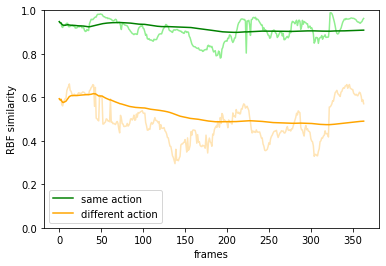

In [97]:
#그래프 용 참고
x , y1 , yy1 = get_cossim_in_json('examples/res/alphapose-dancer_results.json','examples/res/alphapose-right_dance_results.json',usekeyp=[],method="rbf");

x1, y2 , yy2 = get_cossim_in_json('examples/res/alphapose-dancer_results.json','examples/res/alphapose-wrong_dance_results.json',usekeyp=[],method="rbf");

import numpy as np

import matplotlib.pyplot as plt

plt.plot(x, y1, color='lightgreen')

plt.plot(x, y2, color='moccasin')

plt.plot(x, yy1, label='same action', color='green')
plt.plot(x, yy2, label='different action', color='orange')

plt.xlabel('frames')
plt.ylabel('RBF similarity')
plt.ylim([0, 1])
plt.legend()

plt.show();

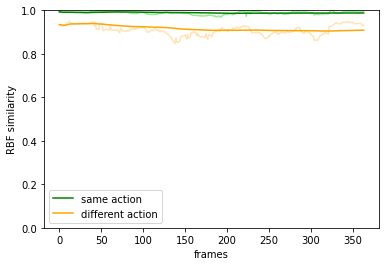

In [96]:
#그래프 용 참고
x , y1 , yy1 = get_cossim_in_json('examples/res/alphapose-dancer_results.json','examples/res/alphapose-right_dance_results.json',usekeyp=[],method="cos");

x1, y2 , yy2 = get_cossim_in_json('examples/res/alphapose-dancer_results.json','examples/res/alphapose-wrong_dance_results.json',usekeyp=[],method="cos");

import numpy as np

import matplotlib.pyplot as plt

plt.plot(x, y1, color='lightgreen')

plt.plot(x, y2, color='moccasin')

plt.plot(x, yy1, label='same action', color='green')
plt.plot(x, yy2, label='different action', color='orange')

plt.xlabel('frames')
plt.ylabel('COS similarity')

plt.ylim([0, 1])

plt.legend()

plt.show();